# Assessmet of key metrics in PanAntarctic experiments: Time series

## To do: change path for volume transport after fixing it

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from datetime import timedelta
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38837,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:41799,Total threads: 4
Dashboard: /proxy/36857/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:39961,


## Load data

In [4]:
path_output_DSW = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
start_time = '1991-01-01'
end_time = '2010-12-31'

In [5]:
exptdict = OrderedDict([
    ('panan_01deg', # 1/10th panantarctic zstar run
     {'expt': 'panant-01-zstar-ACCESSyr2',
      'expt_name': 'panan_01deg_jra55_ryf',
      'expt_str': '1/10°'}),
    ('panan_005deg', # 1/20th panantarctic zstar run
     {'expt': 'panant-005-zstar-ACCESSyr2',
      'expt_name': 'panan_005deg_jra55_ryf',
      'expt_str': '1/20°'})
])

In [6]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]]}

## Load data

In [7]:
%%time
ekeys = ['panan_01deg', 'panan_005deg']
for ekey in ekeys:
    e = exptdict[ekey]
    session = cc.database.create_session()
    
    # Kinetic Energy
    e['KE'] = cc.querying.getvar(
        e['expt'], 'KE', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'KE',
            session, ncfile='ocean.stats.nc',
            decode_times=False, chunks={'Time': '200 MB'})
        var = var.sel(Time=slice(e['KE'].Time.max().values, None))
        e['KE'] = xr.concat((e['KE'], var[1:]), dim='Time')
    e['KE']['Time'] = e['KE'].Time/365 +1
    e['KE'] = e['KE'].sel(Time=slice(start_time, end_time))
    e['KE'] = e['KE'].sum('Layer')
    
    # Global Heat
    e['Heat'] = cc.querying.getvar(
        e['expt'], 'Heat', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'Heat',
            session, ncfile='ocean.stats.nc',
            decode_times=False, chunks={'Time': '200 MB'})
        var = var.sel(Time=slice(e['Heat'].Time.max().values, None))
        e['Heat'] = xr.concat((e['Heat'], var[1:]), dim='Time')
    e['Heat']['Time'] = e['Heat'].Time/365 + 1
    e['Heat'] = e['Heat'].sel(Time=slice(start_time, end_time))
    
    # Global Salt
    e['Salt'] = cc.querying.getvar(
        e['expt'], 'Salt', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'Salt',
            session, ncfile='ocean.stats.nc',
            decode_times=False, chunks={'Time': '200 MB'})
        var = var.sel(Time=slice(e['Salt'].Time.max().values, None))
        e['Salt'] = xr.concat((e['Salt'], var[1:]), dim='Time')
    e['Salt']['Time'] = e['Salt'].Time/365 + 1
    e['Salt'] = e['Salt'].sel(Time=slice(start_time, end_time))
    
    # CFL criteria
    e['CFL'] = cc.querying.getvar(
        e['expt'], 'max_CFL_trans', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'max_CFL_trans',
            session, ncfile='ocean.stats.nc',
            decode_times=False, chunks={'Time': '200 MB'})
        var = var.sel(Time=slice(e['CFL'].Time.max().values, None))
        e['CFL'] = xr.concat((e['CFL'], var[1:]), dim='Time')
    e['CFL']['Time'] = e['CFL'].Time/365 + 1
    e['CFL'] = e['CFL'].sel(Time=slice(start_time, end_time))
    
    # Sea ice extent
    area = cc.querying.getvar(
        e['expt'], 'areacello', session, n=1,
        chunks={'xh': '200 MB', 'yh': '200 MB'})
    siconc = cc.querying.getvar(
        e['expt'], 'siconc', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xT': '200 MB', 'yT': '200 MB'}).rename({'yT':'yh', 'xT':'xh'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'siconc',
            session, frequency='1 monthly',
            start_time=start_time, end_time=end_time,
            chunks={'xT': '200 MB', 'yT': '200 MB'}).rename({'yT':'yh', 'xT':'xh'})
        var = var.sel(time=slice(siconc.time.max().values, None))
        siconc = xr.concat((siconc, var[1:, :]), dim='time')
    e['siext'] = (siconc*area).sum(['xh', 'yh']).compute()
    
    # SWMT on shelf
    ds_SWMT = xr.open_mfdataset(
        path_output_DSW + 'SWMT_' + e['expt_name'] + '_mean_*.nc',
        chunks={'yh': '200MB', 'xh': '200MB'})
    e['swmt'] = (ds_SWMT.binned_salt_transformation +
                 ds_SWMT.binned_heat_transformation)
    # SWMT in four DSW formation regions
    ds_SWMT_DSW = xr.open_mfdataset(
        path_output_DSW + 'SWMT_in_DSW_region_' + e['expt_name']  + '*.nc')
    ds_SWMT_DSW = ds_SWMT_DSW.sel(time=slice(start_time[:4], end_time[:4]))
    e['swmt_DSW'] = (
        ds_SWMT_DSW.binned_salt_transformation_in_DSW_region +
        ds_SWMT_DSW.binned_heat_transformation_in_DSW_region).compute()
    
    # volume transport across 1000m isobath
    contour_depth = 1000
    ds_transp = xr.open_mfdataset(
        path_output_DSW + 'vol_transport_old_isobaths/vol_transp_across_' + str(contour_depth) +
        'm_isobath_' + e['expt_name'] + '*.nc')
    e['transp' + str(contour_depth) + 'm'] = (
        ds_transp.vol_trans_across_contour.assign_coords(
            {'lon': ds_transp.lon[0, :].drop('time'),
             'lat': ds_transp.lat[0, :].drop('time')}).sel(
            time=slice(start_time, end_time)))

    # Drake Passage transport
    umo_2d = cc.querying.getvar(
        e['expt'], 'umo_2d', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xq': '200 MB', 'yh': '200 MB'})
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'umo_2d',
            session, frequency='1 monthly',
            start_time=start_time, end_time=end_time,
            chunks={'xq': '200 MB', 'yh': '200 MB'})
        var = var.sel(time=slice(umo_2d.time.max().values, None))
        umo_2d = xr.concat((umo_2d, var[1:, :]), dim='time')
    e['DP'] = umo_2d.sel(xq=-71,method='nearest').sel(yh=slice(-82, -50)).sum(
        'yh').compute()/1e9
    
    # Transport stream function
    psi = cc.querying.getvar(
        e['expt'], 'vmo', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xh': '200MB', 'yq': '200MB'}).sum('xh')
    if ekey == 'panan_01deg':
        var = cc.querying.getvar(
            'panant-01-zstar-ACCESSyr2_first_run', 'vmo',
            session, frequency='1 monthly',
            start_time=start_time, end_time=end_time,
            chunks={'xh': '200 MB', 'yq': '200 MB'}).sum('xh')
        var = var.sel(time=slice(psi.time.max().values, None))
        psi = xr.concat((psi, var[1:, :]), dim='time')
    e['psi'] = (psi.cumsum('rho2_l')-psi.sum('rho2_l'))/1e9

    
    # Abyssal properties below 3000m, south of 37S
    ds_TS = xr.open_mfdataset(
        path_output_DSW + 'Timeseries_abyssal_properties_monthly_' +
        e['expt_name'] + '*.nc')
    ds_TS = ds_TS.sel(time=slice(start_time, end_time))
    e['T_abyss'] = ds_TS.thetao
    e['S_abyss'] = ds_TS.so
    
    # shelf properties
    ds_shelf = xr.open_mfdataset(
        path_output_DSW + 'Timeseries_shelf_properties_monthly_' +
        e['expt_name'] + '*.nc')
    ds_shelf = ds_shelf.sel(time=slice(start_time, end_time))
    e['SST_shelf'] = ds_shelf.thetao
    e['T_bot_shelf'] = ds_shelf.tob
    e['SSS_shelf'] = ds_shelf.so
    e['S_bot_shelf'] = ds_shelf.sob
    e['rho2_surf_shelf'] = ds_shelf.rhopot2_surface
    e['rho2_bot_shelf'] = ds_shelf.rhopot2_bottom
    e['MLD_shelf'] = ds_shelf.mlotst
    e['ice_conc_shelf'] = ds_shelf.siconc
    e['ice_thick_shelf'] = ds_shelf.sithick

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22722229036864 and this is thread id 22720914908928.
Exception closing connection <sqlite3.Connection object at 0x14aa2c64ed50>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-pa

CPU times: user 29.5 s, sys: 5.31 s, total: 34.9 s
Wall time: 59.8 s


In [8]:
def plot_swmt_timeseries(ekeys, time_slice=None):

    for a in range(4):
        # use sigma bin at 70% of mean SWMT in panan_005deg
        e = exptdict['panan_005deg']
        swmt = e['swmt_DSW']
        # maximum SWMT of time mean 
        swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = swmt.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
    
        plt.subplot(4, 1, a+1)
        for i, ekey in enumerate(ekeys):
            e = exptdict[ekey]
            swmt = e['swmt_DSW']

            swmt[:, :, a].sel(isopycnal_bins=swmt_sig_bin, method='nearest').plot(
                label=ekey)
            plt.ylim(0, 1.4)
            if a == 0:
                plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.2))
            plt.autoscale(enable=True, axis='x', tight=True)
            if a < 3:
                plt.gca().set_xticklabels([])
            plt.xlabel('')
            plt.title('')
            plt.text(.77, .87, str(swmt.area[a].values), fontweight='bold',
                     transform=plt.gca().transAxes)
            plt.text(.88, .87, r'$\sigma_1$=' + str(np.round(swmt_sig_bin.values, 2)),
                     transform=plt.gca().transAxes)

In [9]:
def plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1000, sig=1037.17, time_slice=None):
    
    fig = plt.figure(figsize=(10, 4))

    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lines = []

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        if time_slice is None:
            transp = e['transp' + str(contour_depth) + 'm']
        else:
            transp = e['transp' + str(contour_depth) + 'm'].sel(
                time=time_slice)
        transp = transp.sel(
            rho2_l=slice(sig, None)).sum('rho2_l').cumsum(
            'contour_index')[:, -1].groupby('time.year').mean()
        transp.plot(label=ekey)
        plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('Transport (Sv)')
    plt.title('')
    plt.title('Offshore transport across ' + str(contour_depth) +
              'm isobath for $\sigma_2$ > ' +
              str(sig), loc='left', fontweight='bold')
    plt.show()

## Plots

In [10]:
col = ['tab:blue', 'tab:orange']

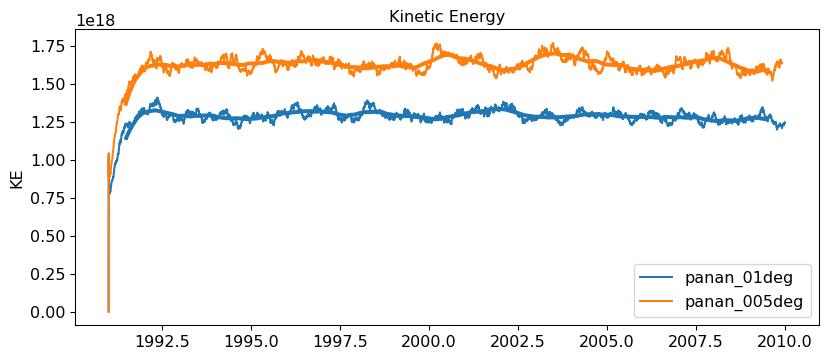

In [11]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['KE'].plot(label=ekey)
    e['KE'].rolling(Time=365, center=True).mean().plot(
        color=col[i], linewidth=3)
plt.legend()
plt.xlabel('')
plt.title('Kinetic Energy')

plt.show()

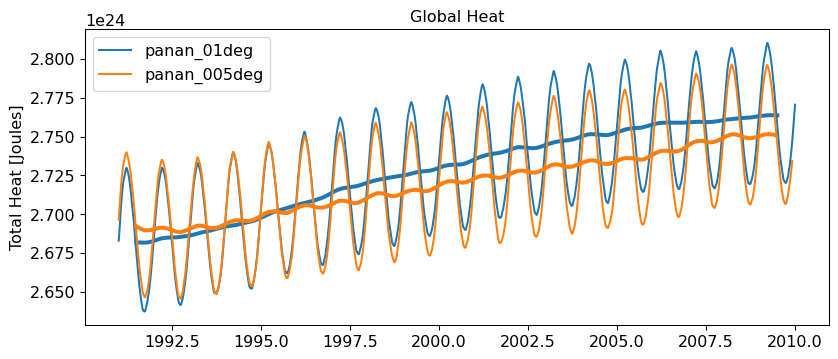

In [12]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['Heat'].plot(label=ekey)
    e['Heat'].rolling(Time=365, center=True).mean().plot(
        color=col[i], linewidth=3)
plt.legend()
plt.xlabel('')
plt.title('Global Heat')

plt.show()

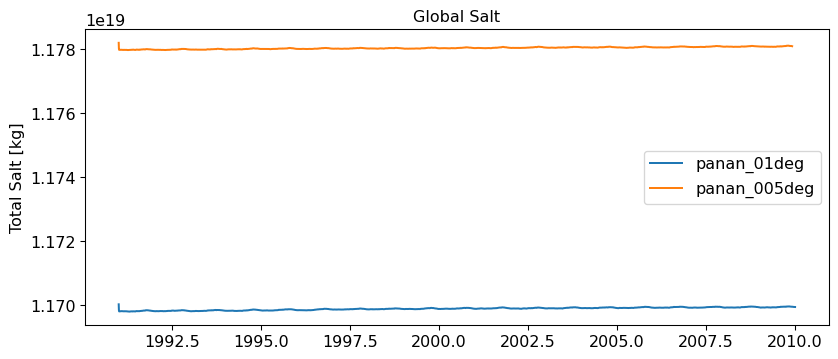

In [13]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['Salt'].plot(label=ekey)
    # e['Salt'].rolling(Time=365, center=True).mean().plot(
    #     color=col[i], linewidth=3)
plt.legend()
plt.xlabel('')
plt.title('Global Salt')

plt.show()

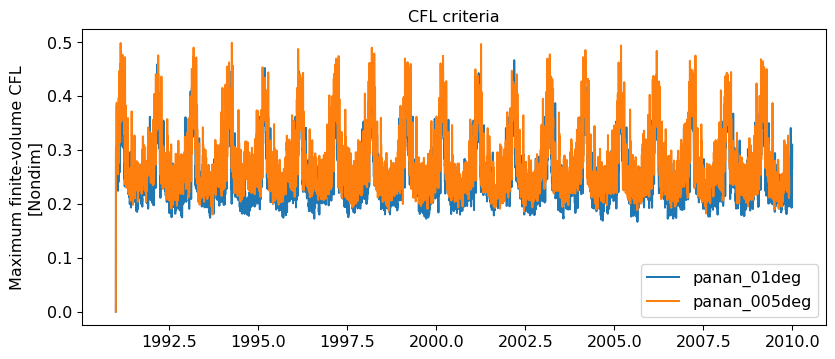

In [14]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['CFL'].plot(label=ekey)
plt.legend()
plt.xlabel('')
plt.title('CFL criteria')

plt.show()

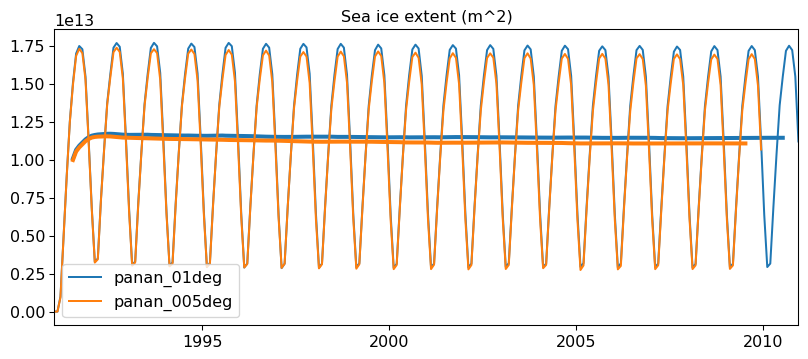

In [15]:
fig = plt.figure(figsize=(10,4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['siext'].plot(label=ekey)
    e['siext'].rolling(time=12, center=True).mean().plot(
        color=col[i], linewidth=3)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title(r'Sea ice extent (m^2)')

plt.show()

### Transports

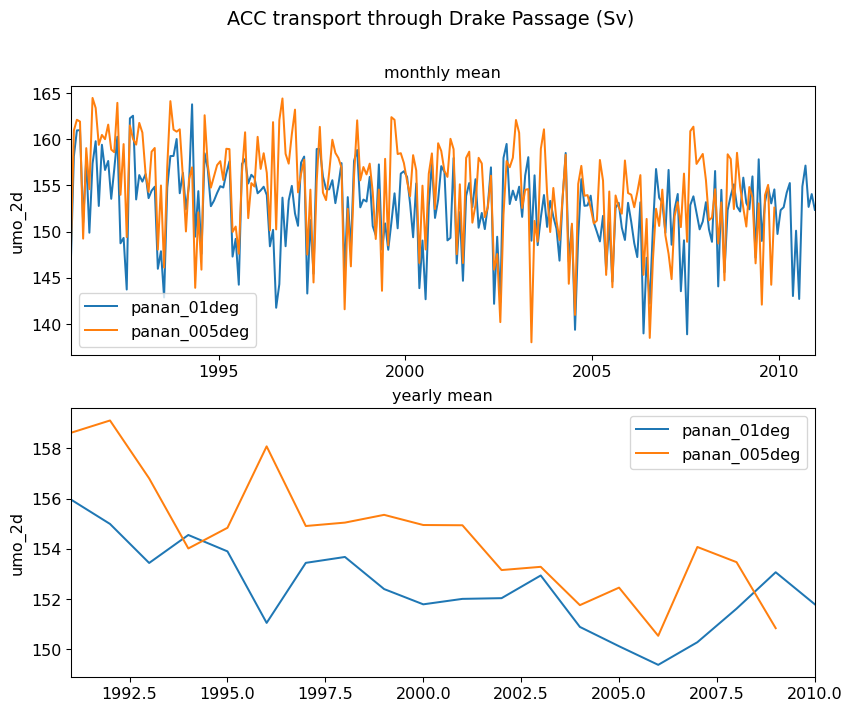

In [16]:
fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['DP'].plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title('monthly mean')

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['DP'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title('yearly mean')
plt.suptitle('ACC transport through Drake Passage (Sv)')

plt.show()

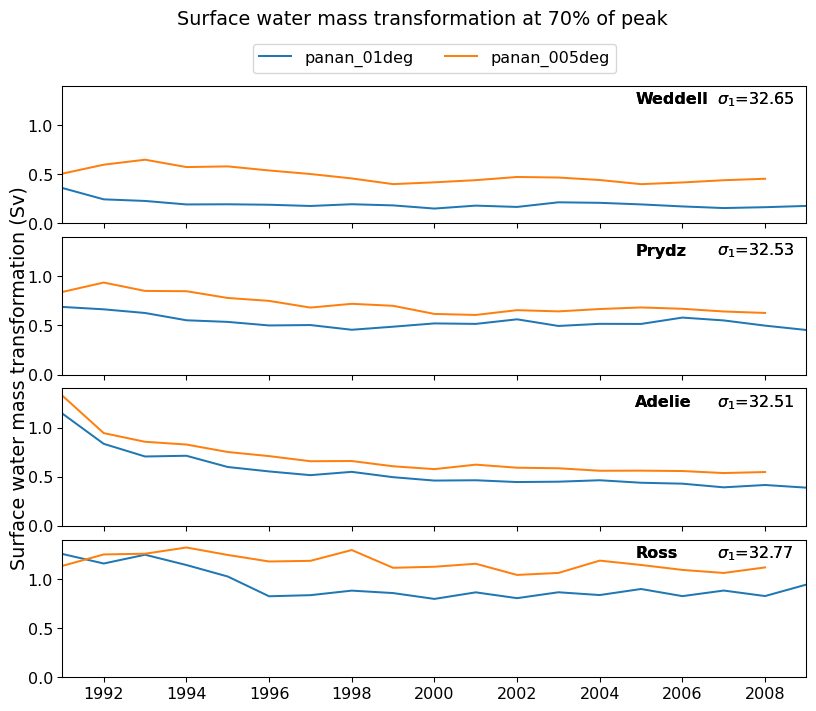

In [17]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.1)
plot_swmt_timeseries(ekeys)
fig.supylabel('Surface water mass transformation (Sv)', x=.07)
fig.suptitle('Surface water mass transformation at 70% of peak')
plt.show()

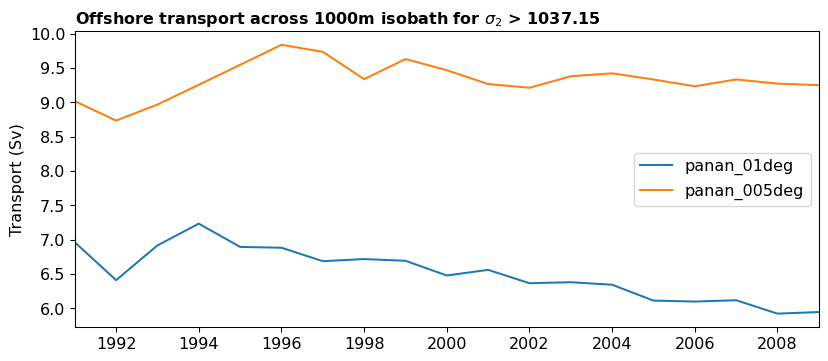

In [18]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1000, sig=1037.15, time_slice=None)

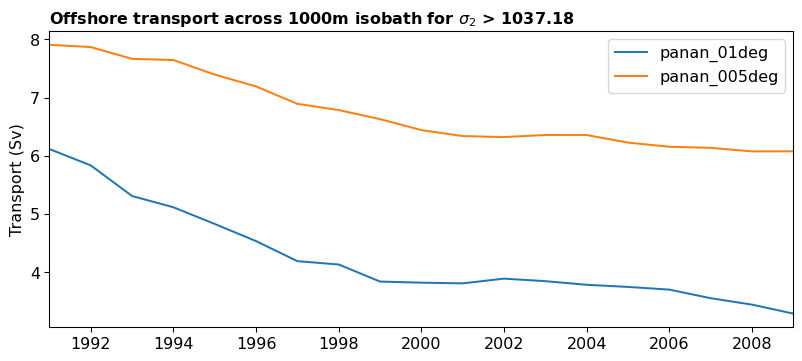

In [19]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1000, sig=1037.18, time_slice=None)

In [20]:
%%time
lat = -60
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt_name'] + ' done')

panan_01deg_jra55_ryf done
panan_005deg_jra55_ryf done
CPU times: user 1min 33s, sys: 34 s, total: 2min 7s
Wall time: 9min 59s


In [21]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt_name'] + ' done')

panan_01deg_jra55_ryf done
panan_005deg_jra55_ryf done
CPU times: user 1min 32s, sys: 33.5 s, total: 2min 6s
Wall time: 9min 43s


In [22]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'] = e['psi'].sel(yq=lat, method='nearest').max(
        dim='rho2_l').compute()
    print(e['expt_name'] + ' done')

panan_01deg_jra55_ryf done
panan_005deg_jra55_ryf done
CPU times: user 1min 5s, sys: 22.3 s, total: 1min 27s
Wall time: 6min 4s


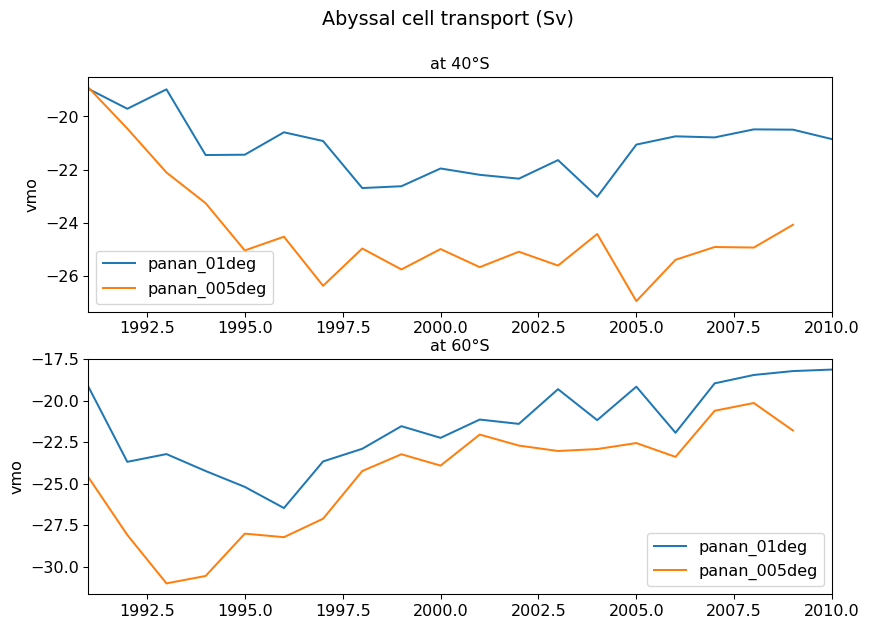

In [23]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('')
plt.legend()
plt.title('at 40°S')

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('')
plt.legend()
plt.title('at 60°S')

plt.suptitle('Abyssal cell transport (Sv)')
plt.show()

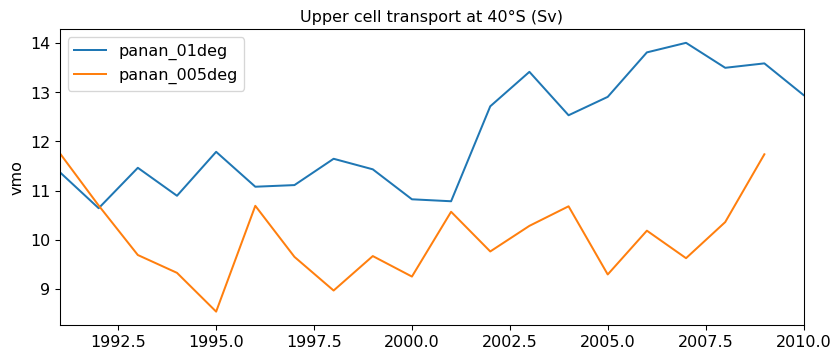

In [24]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title('Upper cell transport at 40°S (Sv)')

plt.show()

### abyssal and shelf T, S, etc

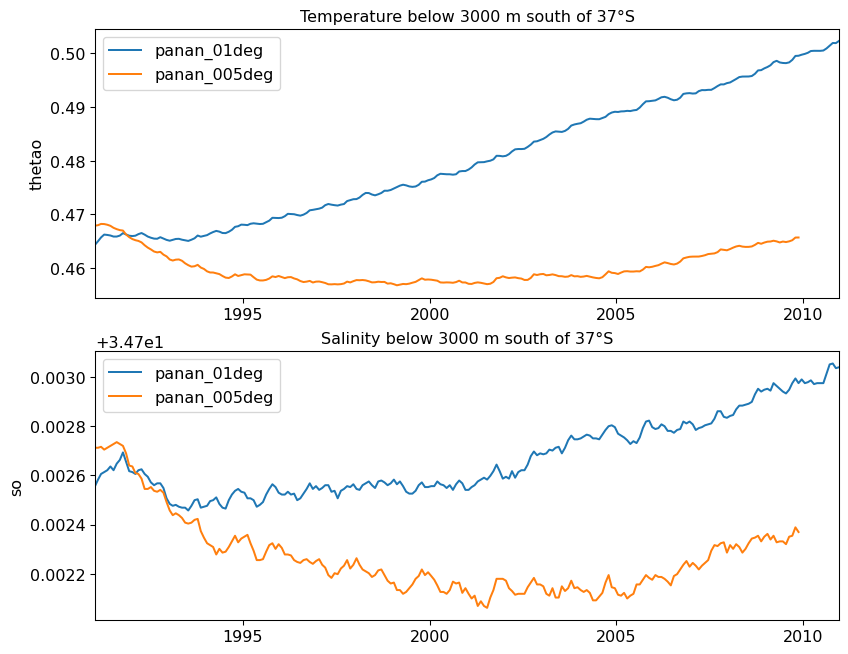

In [25]:
fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_abyss'].plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title('Temperature below 3000 m south of 37°S')

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_abyss'].plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('')
plt.title('Salinity below 3000 m south of 37°S')

plt.show()

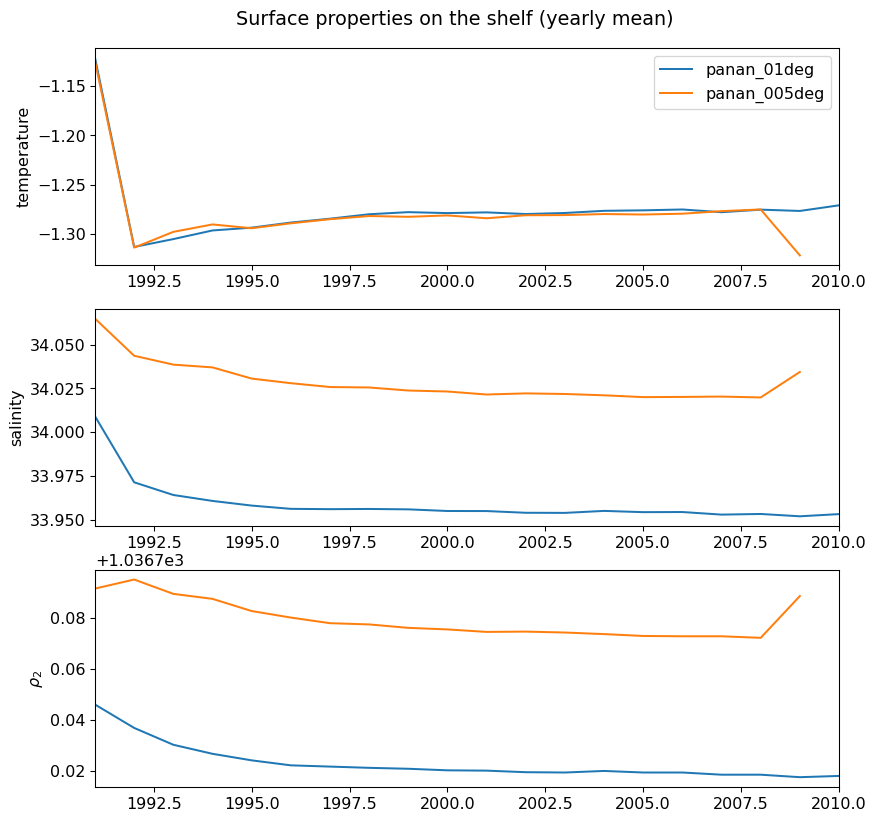

In [26]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SST_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SSS_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['rho2_surf_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\rho_2$')

plt.suptitle('Surface properties on the shelf (yearly mean)', y=.92)
plt.show()

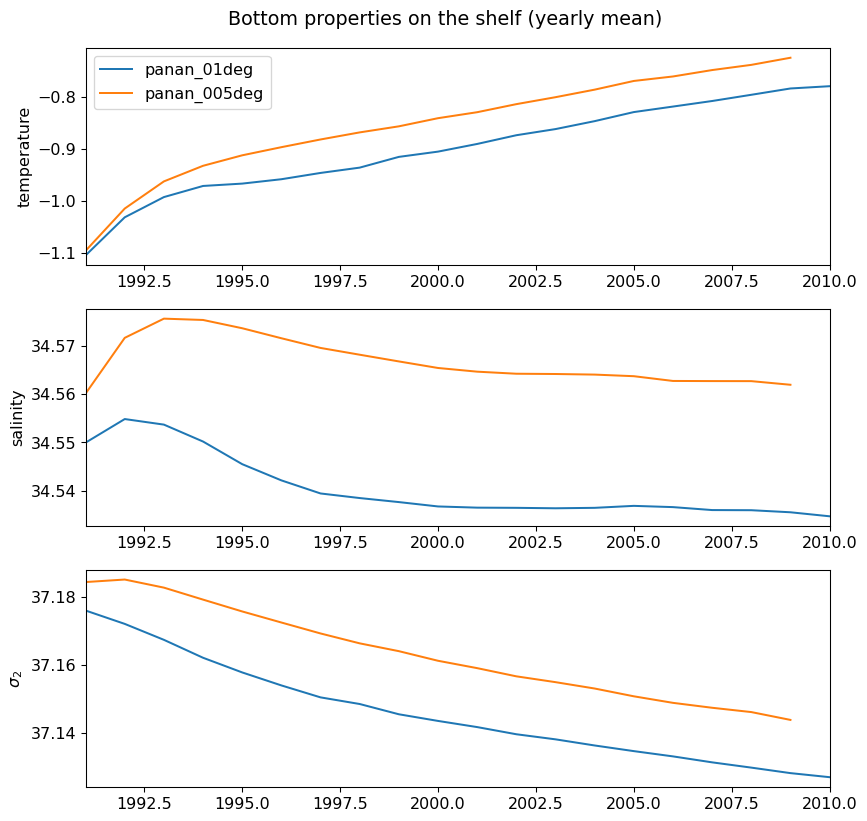

In [27]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_bot_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_bot_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    (e['rho2_bot_shelf']-1000).groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\sigma_2$')

plt.suptitle('Bottom properties on the shelf (yearly mean)', y=.92)
plt.show()

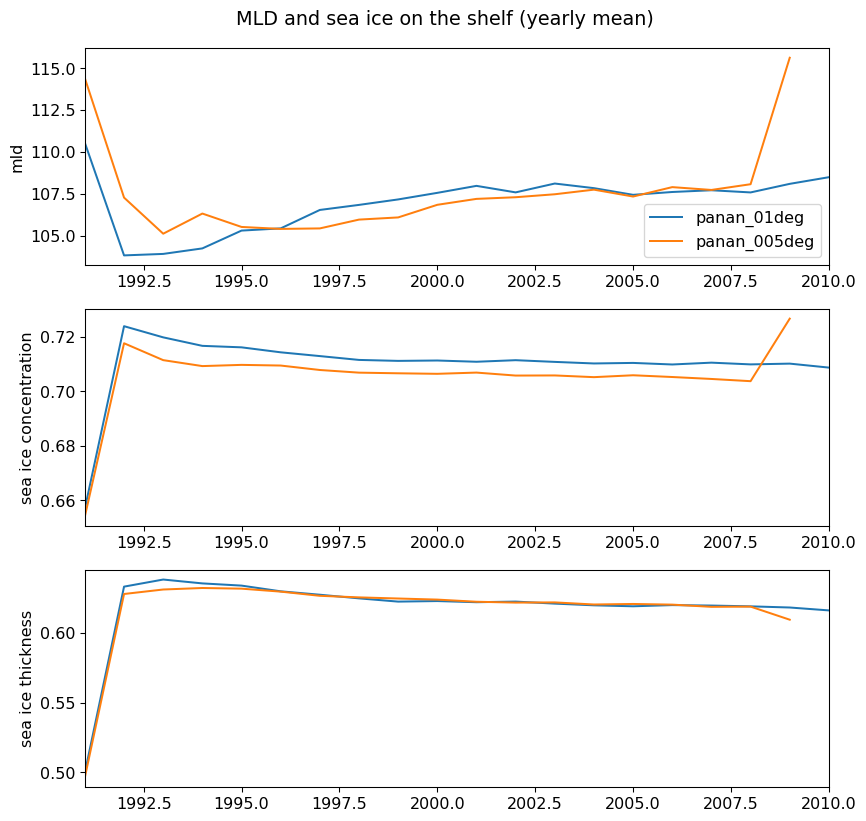

In [28]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['MLD_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('mld')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_conc_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice concentration')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_thick_shelf'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice thickness')

plt.suptitle('MLD and sea ice on the shelf (yearly mean)', y=.92)
plt.show()